# Première partie
## -**Nettoyage des données**


In [24]:
game_col = ['gameid', 'week', 'game', 'gamelength', 'fbtime', 'fdtime', 'fttime', 'fbarontime',
           'heraldtime', 'ckpm']

team_col = ['side', 'team', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'result', 'k', 'd', 'a',
        'teamkills', 'teamdeaths', 'fb','kpm', 'okpm', 'fd', 
        'teamdragkills', 'oppdragkills', 'elementals', 'oppelementals', 'firedrakes', 'waterdrakes',
        'earthdrakes', 'airdrakes', 'elders', 'oppelders', 'herald',
        'heraldtime', 'ft', 'firstmidouter', 'firsttothreetowers',
        'teamtowerkills', 'opptowerkills', 'fbaron',
        'teambaronkills', 'oppbaronkills', 'epicmonsterkills']

players_col = ['position', 'player', 'team',
       'champion', 'k', 'd', 'a' ,'doubles',
       'triples', 'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime',
       'kpm', 'okpm','dmgtochamps', 'dmgtochampsperminute', 'dmgshare',
       'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm',
       'visionwards', 'visionwardbuys', 'totalgold', 'earnedgpm', 'goldspent',
       'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle',
       'monsterkillsenemyjungle', 'cspm', 'goldat10', 'oppgoldat10', 'gdat10',
       'goldat15', 'oppgoldat15', 'gdat15', 'xpat10', 'oppxpat10', 'xpdat10',
       'csat10', 'oppcsat10', 'csdat10', 'csat15', 'oppcsat15', 'csdat15']

In [25]:
import pandas as pd
import numpy as np
full_df = pd.read_csv('data/lol_worlds_2019.csv', na_values = ' ').drop(['url', 'league', 'split', 'date', 'patchno', 'playerid'], axis = 1).set_index('gameid', drop = False)

In [26]:
full_df.earnedgoldshare = np.round(full_df.earnedgoldshare * 100, decimals = 2)
full_df.wardshare = np.round(full_df.wardshare * 100, decimals = 2)
full_df.dmgshare = np.round(full_df.dmgshare * 100, decimals = 2)
full_df['epicmonsterkills'] = full_df.teamdragkills + full_df.teambaronkills + full_df.herald

In [27]:
team_df = full_df[full_df.position == "Team"]
team_df = team_df.dropna(axis = 1, how = 'all')

players_df = full_df[full_df.position != "Team"]
players_df = players_df.dropna(axis = 1, how = 'all')
players_df['kda'] = (players_df.k + players_df.a) / players_df.d.replace(0, 1)

nb_games = team_df[team_df.result == 1].shape[0]
nb_teams = team_df.team.unique().shape[0]
nb_players = players_df.player.unique().shape[0]
print(nb_games, nb_teams, nb_players)

119 24 127


**Statistiques globales**

In [28]:
gamelen_df = team_df[['gamelength']][team_df.result == 1]

cs_df = players_df[['position', 'csat10', 'csat15']]
xp_df = players_df[['position','xpat10']]

stats_df = players_df[['position', 'dmgshare', 'earnedgoldshare', 'earnedgpm', 'wardshare', 'kda']]

**Champions**

In [90]:
bans_df = team_df.melt(id_vars= 'gameid',value_vars=['ban1','ban2', 'ban3', 'ban4', 'ban5']).drop('variable', axis = 1).set_index('gameid').rename(columns={'value': 'bans'})
pick_df = players_df[['result','champion', 'position']]

**Side**

In [118]:
red_df = team_df[['result', 'epicmonsterkills', 'teamdragkills','herald']][team_df.side == 'Red']
blue_df = team_df[['result', 'epicmonsterkills']][team_df.side == 'Blue']

**Objectifs**

In [31]:
drakes_df = team_df[['result','teamdragkills', 'fd','fdtime', 'firedrakes', 'waterdrakes','earthdrakes', 'airdrakes']]
herald_df = team_df[['result','herald', 'heraldtime']]
baron_df = team_df[['result', 'teambaronkills', 'fbaron','fbarontime']]
elder_df = team_df[['result', 'elders']]
turrets_df = team_df[['result','ft', 'fttime','teamtowerkills']]

# Deuxième partie
## -**Analyse des données**

**Longueur de partie moyenne, partie la plus longue, partie la plus courte.**

La longueur de partie moyenne est de 33 minutes la médiane est de 32,
la partie la plus longue et la plus courte ont duré respectivement de 63 et 23 minutes
L'écart-type de la longueur de partie est de 6


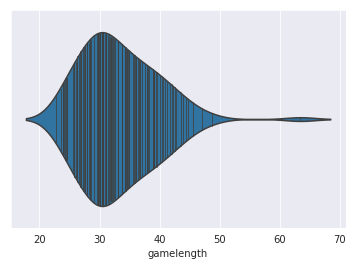

In [134]:
gamelen_mean = int(np.round(gamelen_df.mean()))
gamelen_med = int(np.round(gamelen_df.median()))
gamelen_max = int(np.round(gamelen_df.max()))
gamelen_min = int(np.round(gamelen_df.min()))
gamelen_std = int(np.round(gamelen_df.std()))
print('La longueur de partie moyenne est de {} minutes la médiane est de {},\nla partie la plus longue et la plus courte ont duré respectivement de {} et {} minutes'.format(gamelen_mean, gamelen_med, gamelen_max, gamelen_min))
print("L'écart-type de la longueur de partie est de {}".format(gamelen_std))
gamelen_ab = gamelen_df[gamelen_df.gamelength > (2 * gamelen_std + gamelen_mean)]

import matplotlib.pyplot as plt
import seaborn as sns

sns.violinplot(data = gamelen_df, x = 'gamelength', inner = 'stick')
plt.show()

**Creep score (10 min , 15 min), CS diff / poste**

In [37]:
def getMeanPerPos(df, column):
    top = int(np.round(df[df.position == 'Top'][column].mean()))
    jgl = int(np.round(df[df.position == 'Jungle'][column].mean()))
    mid = int(np.round(df[df.position == 'Middle'][column].mean()))
    bot = int(np.round(df[df.position == 'ADC'][column].mean()))
    sup = int(np.round(df[df.position == 'Support'][column].mean()))
    return top, jgl, mid, bot, sup

def getMedianPerPos(df, column):
    top = int(np.round(df[df.position == 'Top'][column].median()))
    jgl = int(np.round(df[df.position == 'Jungle'][column].median()))
    mid = int(np.round(df[df.position == 'Middle'][column].median()))
    bot = int(np.round(df[df.position == 'ADC'][column].median()))
    sup = int(np.round(df[df.position == 'Support'][column].median()))
    return top, jgl, mid, bot, sup

#csat10
top,jgl,mid,bot,sup = getMeanPerPos(cs_df, 'csat10')
print('Moyenne des Creep score à 10 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs\n'.format(top,jgl,mid,bot,sup))
top,jgl,mid,bot,sup = getMedianPerPos(cs_df, 'csat10')
print('Mediane des Creep score à 10 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs\n'.format(top,jgl,mid,bot,sup))

#csat15
top,jgl,mid,bot,sup = getMeanPerPos(cs_df, 'csat15')
print('Moyenne des Creep score à 15 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs\n'.format(top,jgl,mid,bot,sup))
top,jgl,mid,bot,sup = getMedianPerPos(cs_df, 'csat15')
print('Mediane des Creep score à 15 min :\n-Top {}cs\n-Jungle {}cs\n-Middle {}cs\n-Bot {}cs\n-Support {}cs'.format(top,jgl,mid,bot,sup))

Moyenne des Creep score à 10 min :
-Top 75cs
-Jungle 57cs
-Middle 86cs
-Bot 84cs
-Support 9cs

Mediane des Creep score à 10 min :
-Top 76cs
-Jungle 57cs
-Middle 86cs
-Bot 85cs
-Support 12cs

Moyenne des Creep score à 15 min :
-Top 120cs
-Jungle 86cs
-Middle 137cs
-Bot 134cs
-Support 16cs

Mediane des Creep score à 15 min :
-Top 121cs
-Jungle 85cs
-Middle 139cs
-Bot 136cs
-Support 19cs


**Xp(10 min) diff / poste.**

In [38]:
#xpat10
top,jgl,mid,bot,sup = getMeanPerPos(xp_df, 'xpat10')
print('Moyenne en expérience à 10 min :\n-Top {}\n-Jungle {}\n-Middle {}\n-Bot {}\n-Support {}\n'.format(top,jgl,mid,bot,sup))
top,jgl,mid,bot,sup = getMedianPerPos(xp_df, 'xpat10')
print('Médiane en expérience à 10 min :\n-Top {}\n-Jungle {}\n-Middle {}\n-Bot {}\n-Support {}'.format(top,jgl,mid,bot,sup))


Moyenne en expérience à 10 min :
-Top 4414
-Jungle 3335
-Middle 4626
-Bot 3307
-Support 2634

Médiane en expérience à 10 min :
-Top 4444
-Jungle 3352
-Middle 4634
-Bot 3300
-Support 2612


**Stats (KDA, Dmg share, Gold share, Golds/minutes, Wards share) / poste.**

In [39]:
#kda
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'kda')
print('Moyenne du kda :\n-Top {}\n-Jungle {}\n-Middle {}\n-Bot {}\n-Support {}\n'.format(top,jgl,mid,bot,sup))
top,jgl,mid,bot,sup = getMedianPerPos(stats_df, 'kda')
print('Médiane du kda :\n-Top {}\n-Jungle {}\n-Middle {}\n-Bot {}\n-Support {}\n'.format(top,jgl,mid,bot,sup))

#Dmg share
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'dmgshare')
print('Moyenne de la répartition des dégats:\n-Top {}%\n-Jungle {}%\n-Middle {}%\n-Bot {}%\n-Support {}%\n'.format(top,jgl,mid,bot,sup))
top,jgl,mid,bot,sup = getMedianPerPos(stats_df, 'dmgshare')
print('Médiane de la répartition des dégats:\n-Top {}%\n-Jungle {}%\n-Middle {}%\n-Bot {}%\n-Support {}%\n'.format(top,jgl,mid,bot,sup))

#Gold share
top,jgl,mid,bot,sup = getMeanPerPos(stats_df, 'earnedgoldshare')
print('Moyenne de la répartition des golds:\n-Top {}%\n-Jungle {}%\n-Middle {}%\n-Bot {}%\n-Support {}%\n'.format(top,jgl,mid,bot,sup))
top,jgl,mid,bot,sup = getMedianPerPos(stats_df, 'earnedgoldshare')
print('Médiane de la répartition des golds:\n-Top {}%\n-Jungle {}%\n-Middle {}%\n-Bot {}%\n-Support {}%\n'.format(top,jgl,mid,bot,sup))

Moyenne du kda :
-Top 4
-Jungle 5
-Middle 5
-Bot 5
-Support 4

Médiane du kda :
-Top 2
-Jungle 3
-Middle 4
-Bot 4
-Support 3

Moyenne de la répartition des dégats:
-Top 25%
-Jungle 16%
-Middle 25%
-Bot 25%
-Support 9%

Médiane de la répartition des dégats:
-Top 25%
-Jungle 15%
-Middle 24%
-Bot 25%
-Support 8%

Moyenne de la répartition des golds:
-Top 23%
-Jungle 17%
-Middle 23%
-Bot 27%
-Support 10%

Médiane de la répartition des golds:
-Top 23%
-Jungle 17%
-Middle 23%
-Bot 27%
-Support 10%



**Les champions les plus Picks/Bans.**

**Les champions avec le plus haut/bas winrate.**

In [117]:
def getPickDf(pick_df, bans_df):
    champ_df = pd.read_csv('data/champions_list.csv', header = None).T.set_index(0)
    champ_df['bans'] = bans_df.bans.value_counts()
    champ_df.bans = champ_df.bans.fillna(0)
    champ_df['picks'] = pick_df.champion.value_counts()
    champ_df.picks = champ_df.picks.fillna(0)
    champ_df['wins'] = pick_df[pick_df.result == 1].champion.value_counts()
    champ_df.wins = champ_df.wins.fillna(0)
    champ_df['presence'] = champ_df.bans + champ_df.picks
    champ_df['prerate'] = np.round(champ_df.presence / nb_games * 100).astype(int)
    champ_df['banrate'] = np.round(champ_df.bans / nb_games * 100).astype(int)
    champ_df['pickrate'] = np.round(champ_df.picks / nb_games * 100).astype(int)
    champ_df['winrate'] = np.round(champ_df.wins / champ_df.picks * 100).fillna(0).astype(int)
    return champ_df

def displayPickDf(df):
    display(df[df.picks > 0].pickrate.sort_values(ascending = False).head(10))
    display(df[df.picks > 0].prerate.sort_values(ascending = False).head(10))
    display(df[(df.picks >= 5) & (df.banrate <= 33)].winrate.sort_values(ascending = False).head(10))

top_df = getPickDf(pick_df[pick_df.position == 'Top'], bans_df)
jungle_df = getPickDf(pick_df[pick_df.position == 'Jungle'], bans_df)
mid_df = getPickDf(pick_df[pick_df.position == 'Middle'], bans_df)
adc_df = getPickDf(pick_df[pick_df.position == 'ADC'], bans_df)
supp_df = getPickDf(pick_df[pick_df.position == 'Support'], bans_df)

display(top_df.banrate.sort_values(ascending = False).head(10))
print('Top')
displayPickDf(top_df)
print('Jungle')
displayPickDf(jungle_df)
print('Middle')
displayPickDf(mid_df)
print('ADC')
displayPickDf(adc_df)
print('Support')
displayPickDf(supp_df)

0
Pantheon    99
Qiyana      72
Syndra      55
Renekton    51
Akali       45
Xayah       38
LeBlanc     37
Kayle       36
Elise       29
Gragas      29
Name: banrate, dtype: int64

Top


0
Gangplank    32
Renekton     24
Gnar         15
Jayce        13
Vladimir     12
Akali         9
Camille       9
Kayle         9
Aatrox        8
Ornn          7
Name: pickrate, dtype: int64

0
Renekton     75
Qiyana       73
Gangplank    60
Akali        55
Kayle        45
Ryze         28
Vladimir     25
Jayce        24
Gnar         21
Tristana     20
Name: prerate, dtype: int64

0
Ornn         75
Ryze         71
Kennen       71
Gnar         61
Vladimir     57
Kled         57
Gangplank    55
Jayce        47
Camille      45
Aatrox       33
Name: winrate, dtype: int64

Jungle


0
Lee Sin      48
Gragas       34
Elise        27
Rek'Sai      18
Jarvan IV    15
Nocturne      9
Qiyana        9
Taliyah       8
Olaf          8
Skarner       7
Name: pickrate, dtype: int64

0
Qiyana       82
Gragas       62
Lee Sin      59
Elise        55
Rek'Sai      36
Jarvan IV    26
Olaf         25
Nocturne     16
Skarner      13
Taliyah      11
Name: prerate, dtype: int64

0
Gragas       68
Taliyah      67
Olaf         60
Lee Sin      53
Rek'Sai      50
Elise        50
Jarvan IV    39
Nocturne     27
Karthus      20
Ekko         20
Name: winrate, dtype: int64

Middle


0
Ryze            24
Akali           20
LeBlanc         18
Syndra          18
Orianna         10
Kayle            9
Qiyana           8
Tristana         8
Galio            7
Twisted Fate     7
Name: pickrate, dtype: int64

0
Pantheon        100
Qiyana           81
Syndra           73
Akali            66
LeBlanc          55
Renekton         55
Ryze             46
Kayle            45
Twisted Fate     26
Tristana         25
Name: prerate, dtype: int64

0
Yasuo           60
Ryze            59
Orianna         58
Cassiopeia      57
Twisted Fate    50
Lissandra       50
Corki           50
Tristana        44
Galio           38
Name: winrate, dtype: int64

ADC


0
Kai'Sa          60
Xayah           47
Ezreal          18
Lucian           8
Yasuo            8
Varus            8
Syndra           7
Garen            7
Heimerdinger     5
Tristana         4
Name: pickrate, dtype: int64

0
Xayah       85
Kai'Sa      74
Syndra      62
Kayle       37
Ezreal      28
Yasuo       23
Tristana    22
Lucian      18
Irelia      17
Morgana     16
Name: prerate, dtype: int64

0
Yasuo           67
Varus           67
Kai'Sa          52
Heimerdinger    50
Ezreal          41
Tristana        40
Garen           38
Lucian          20
Name: winrate, dtype: int64

Support


0
Nautilus      40
Rakan         35
Thresh        29
Leona         17
Alistar       12
Yuumi         11
Pyke           9
Gragas         8
Morgana        7
Blitzcrank     7
Name: pickrate, dtype: int64

0
Nautilus    61
Rakan       59
Thresh      37
Gragas      36
Yuumi       33
Leona       25
Morgana     22
Pyke        19
Alistar     18
Galio       14
Name: prerate, dtype: int64

0
Tahm Kench    71
Leona         65
Morgana       62
Gragas        56
Rakan         55
Nautilus      52
Thresh        46
Yuumi         38
Blitzcrank    38
Pyke          36
Name: winrate, dtype: int64

**Side : Winrate, nombre d'objectifs neutres.**

In [129]:
red_wrate = int(np.round(red_df.result.sum() / nb_games * 100))
print("le winrate redside {}%, blueside {}%".format(red_wrate, 100 - red_wrate))
red_epic_med = red_df.epicmonsterkills.median()
blue_epic_med = blue_df.epicmonsterkills.median()
print("La mediane des monstres epiques tués est de :red {}, blue {}".format(red_epic_med, blue_epic_med))

le winrate redside 48%, blueside 52%
La mediane des monstres epiques tués est de :red 4.0, blue 4.0
